In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from ripser import ripser
from persim import plot_diagrams

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""Import dataset"""

# Import data
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [3]:
"""Preprocess Data: Remove Duplicates and Missing Values"""

# Check initial counts
initial_count = X.shape[0]

# Remove duplicates
X_clean = X.drop_duplicates()
y_clean = y.loc[X_clean.index]
duplicates_removed = initial_count - X_clean.shape[0]

# Remove missing values
after_duplicates = X_clean.shape[0]
mask = ~X_clean.isnull().any(axis=1)
X_clean = X_clean[mask]
y_clean = y_clean[mask]
missing_removed = after_duplicates - X_clean.shape[0]

# Summary
print(f"Original shape: {initial_count}")
print(f"Duplicates removed: {duplicates_removed}")
print(f"Missing values removed: {missing_removed}")
print(f"Total removed: {duplicates_removed + missing_removed}")
print(f"Cleaned shape: {X_clean.shape[0]}")

# Update X and y
X = X_clean.reset_index(drop=True)
y = y_clean.reset_index(drop=True)

Original shape: 303
Duplicates removed: 0
Missing values removed: 6
Total removed: 6
Cleaned shape: 297


In [ ]:
"""Standardize the Features"""

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) # Convert back to DataFrame

In [5]:
"""Compute Euclidean distance matrix"""

distance_matrix = pairwise_distances(X_scaled, metric='euclidean')


H0 (connected components): 297 features
H1 (loops/cycles): 261 features
H2 (voids): 182 features


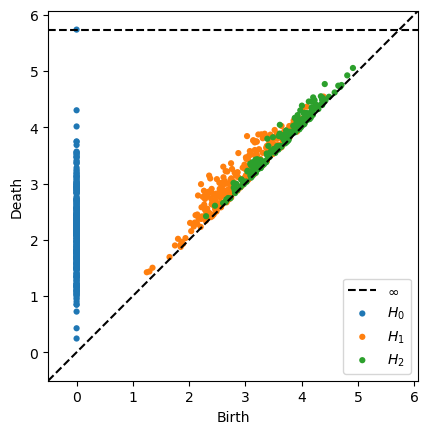

In [6]:
"""Vietoris-Rips Filtration and Persistent Homology Computation"""

# Vietoris-Rips filtration set-up
max_dimension = 2  # Up to 2-dimensional homology (H0, H1, H2)
max_edge_length = np.percentile(distance_matrix[distance_matrix > 0], 50)  # Use median distance

# Compute persistent homology
result = ripser(distance_matrix, maxdim=max_dimension, distance_matrix=True)

# Extract persistence diagrams
diagrams = result['dgms']

# Print out H0, H1, H2
print(f"\nH0 (connected components): {len(diagrams[0])} features")
print(f"H1 (loops/cycles): {len(diagrams[1])} features")
if len(diagrams) > 2:
    print(f"H2 (voids): {len(diagrams[2])} features")

# Plot persistence diagrams
plot_diagrams(diagrams, show=True)

Stable Rank (Betti) curves computed!
Epsilon range: [0, 4.9730] with 100 steps


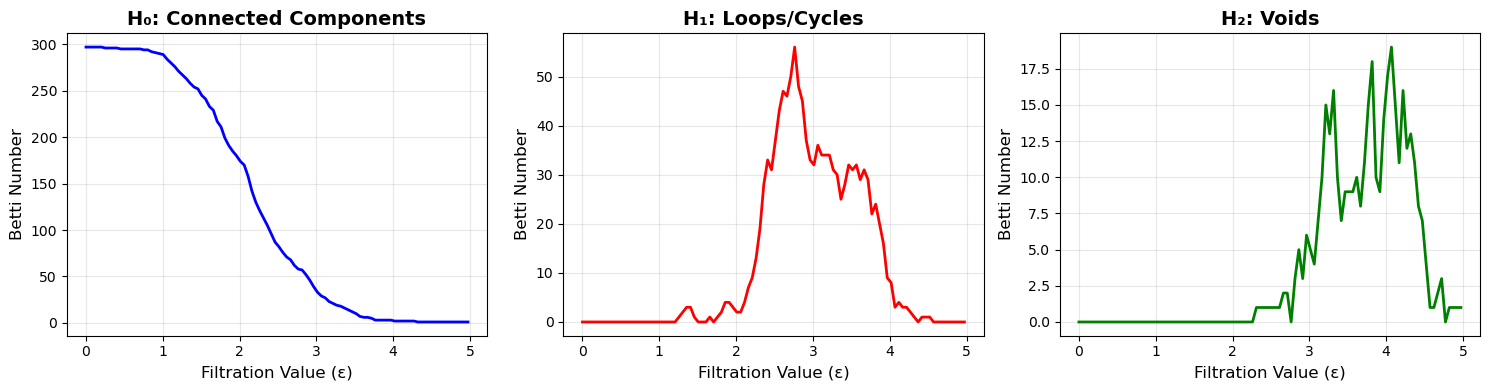

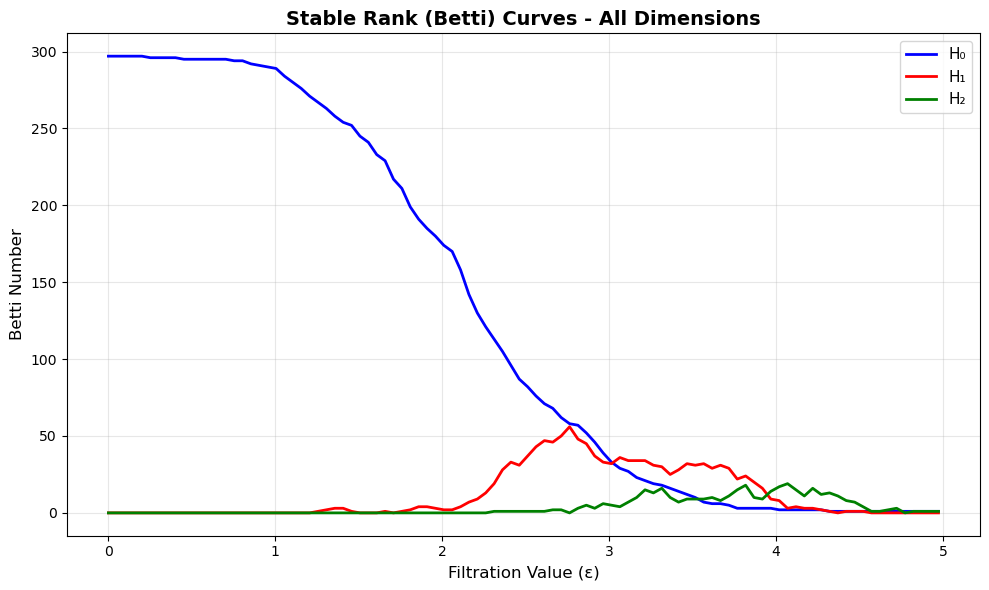

In [ ]:
"""Stable Rank (Betti) Curves Computation and Visualization"""

# Filtration scales
epsilon_values = np.linspace(0, max_edge_length, 100)

# Compute Betti numbers 
betti_0 = [np.sum((diagrams[0][:,0] <= eps) & (diagrams[0][:,1] > eps)) for eps in epsilon_values]
betti_1 = [np.sum((diagrams[1][:,0] <= eps) & (diagrams[1][:,1] > eps)) for eps in epsilon_values]
betti_2 = [np.sum((diagrams[2][:,0] <= eps) & (diagrams[2][:,1] > eps)) for eps in epsilon_values] if len(diagrams) > 2 else []

print("Stable Rank (Betti) curves computed!")
print(f"Epsilon range: [0, {max_edge_length:.4f}] with {len(epsilon_values)} steps")

# Plot individual Betti curves
titles = ['H₀: Connected Components', 'H₁: Loops/Cycles', 'H₂: Voids']
colors = ['b', 'r', 'g']
bettis = [betti_0, betti_1, betti_2]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes):
    if i < len(bettis) and len(bettis[i]) > 0:
        ax.plot(epsilon_values, bettis[i], colors[i] + '-', linewidth=2)
    else:
        ax.text(0.5, 0.5, 'No features', ha='center', va='center')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Filtration Value (ε)', fontsize=12)
    ax.set_ylabel('Betti Number', fontsize=12)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Combined plot
plt.figure(figsize=(10, 6))
for i in range(len(bettis)):
    if len(bettis[i]) > 0:
        plt.plot(epsilon_values, bettis[i], colors[i] + '-', linewidth=2, label=titles[i].split(":")[0])
plt.xlabel('Filtration Value (ε)', fontsize=12)
plt.ylabel('Betti Number', fontsize=12)
plt.title('Stable Rank (Betti) Curves - All Dimensions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
"""L1 Distance (Persistence aka liftetimes) Computation for each homology dimension"""

# H0
persistence_0 = diagrams[0][:, 1] - diagrams[0][:, 0]
persistence_0 = persistence_0[np.isfinite(persistence_0)]  # remove inf deaths

# H1
persistence_1 = diagrams[1][:, 1] - diagrams[1][:, 0]
persistence_1 = persistence_1[np.isfinite(persistence_1)]

# H2
persistence_2 = diagrams[2][:, 1] - diagrams[2][:, 0]
persistence_2 = persistence_2[np.isfinite(persistence_2)]

# Print 
print(f"H0 persistence - Mean: {persistence_0.mean():.4f}, Max: {persistence_0.max():.4f}")
print(f"H1 persistence - Mean: {persistence_1.mean():.4f}, Max: {persistence_1.max():.4f}")
print(f"H2 persistence - Mean: {persistence_2.mean():.4f}, Max: {persistence_2.max():.4f}")


H0 persistence - Mean: 2.1493, Max: 4.3016
H1 persistence - Mean: 0.2303, Max: 0.8127
H2 persistence - Mean: 0.1049, Max: 0.4307


Random Forest — Raw Data
Binary Classification Accuracy: 88.33%
Multi-Class Classification Accuracy: 60.00%


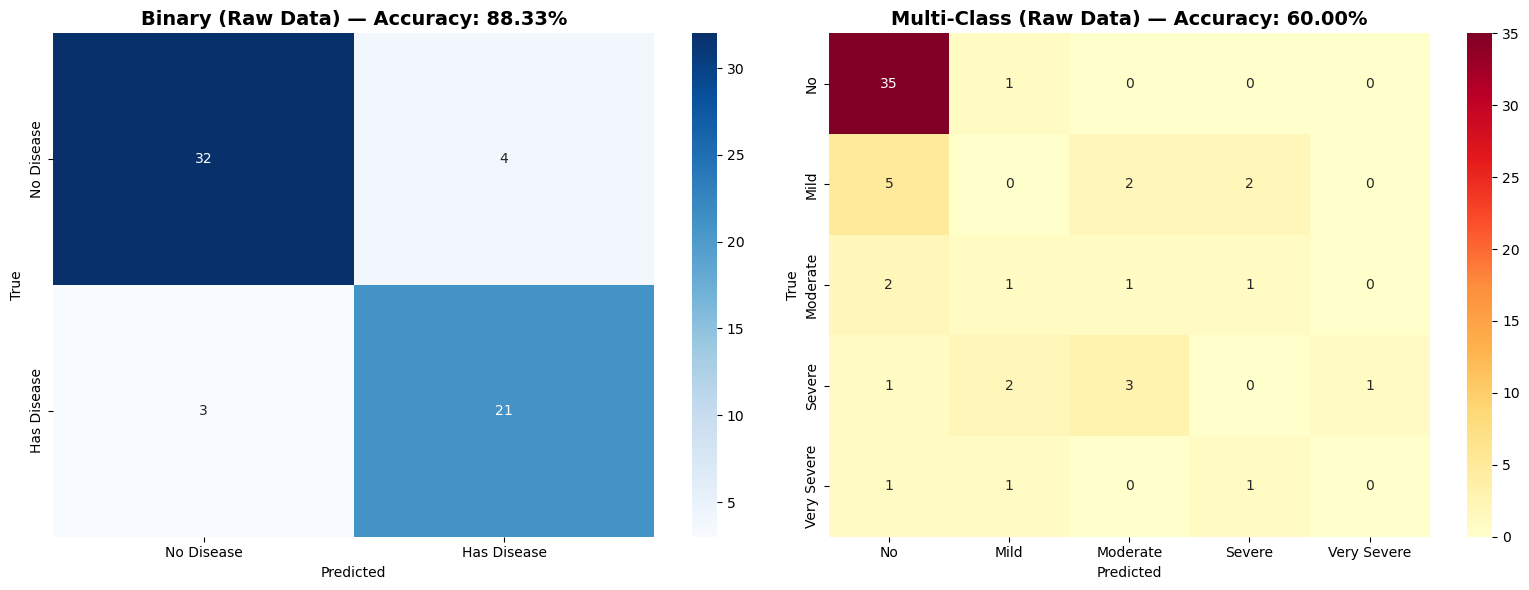

In [9]:
"""Random Forest Classification Using Raw Data"""

# Binary classification (y > 0 = has disease)
y_binary = (y > 0).astype(int)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42
)

clf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
clf_bin.fit(X_train_bin, y_train_bin)
y_pred_bin = clf_bin.predict(X_test_bin)
acc_bin = accuracy_score(y_test_bin, y_pred_bin)

# Multi-class classification (0–4 severity)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

clf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
clf_multi.fit(X_train_multi, y_train_multi)
y_pred_multi = clf_multi.predict(X_test_multi)
acc_multi = accuracy_score(y_test_multi, y_pred_multi)

# Print results
print("Random Forest — Raw Data")
print(f"Binary Classification Accuracy: {acc_bin:.2%}")
print(f"Multi-Class Classification Accuracy: {acc_multi:.2%}")

# Plot confusion matrices 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'],
            ax=axes[0])
axes[0].set_title(f'Binary (Raw Data) — Accuracy: {acc_bin:.2%}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

# Multi-class
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            yticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            ax=axes[1])
axes[1].set_title(f'Multi-Class (Raw Data) — Accuracy: {acc_multi:.2%}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


Random Forest — Topological Features
Binary Classification Accuracy: 50.00%
Multi-Class Classification Accuracy: 48.33%


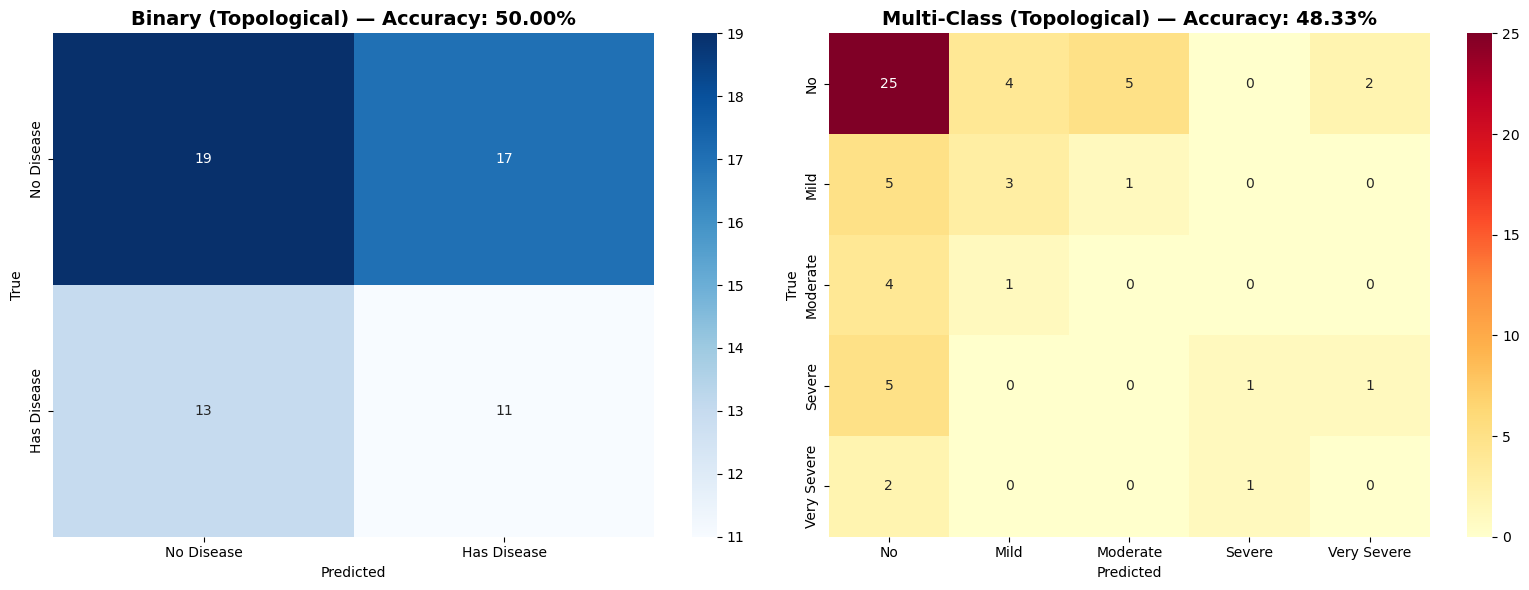

In [10]:
"""Random Forest with Topological Features"""

# Build per-sample topological features
k_neighbors = 10
X_topo = np.array([
    [
        np.mean(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.std(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.min(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.max(sorted(distance_matrix[i])[1:k_neighbors+1]),
        np.median(sorted(distance_matrix[i])[1:k_neighbors+1])
    ]
    for i in range(distance_matrix.shape[0])
])

y_binary = (y > 0).astype(int)

# Binary 
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_topo, y_binary, test_size=0.2, random_state=42)
clf_b = RandomForestClassifier(n_estimators=100, random_state=42)
clf_b.fit(X_train_b, y_train_b)
y_pred_b = clf_b.predict(X_test_b)
acc_b = accuracy_score(y_test_b, y_pred_b)

# Multi-class
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_topo, y, test_size=0.2, random_state=42)
clf_m = RandomForestClassifier(n_estimators=100, random_state=42)
clf_m.fit(X_train_m, y_train_m)
y_pred_m = clf_m.predict(X_test_m)
acc_m = accuracy_score(y_test_m, y_pred_m)

# Print accuracy results
print("Random Forest — Topological Features")
print(f"Binary Classification Accuracy: {acc_b:.2%}")
print(f"Multi-Class Classification Accuracy: {acc_m:.2%}")


# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary
cm_b = confusion_matrix(y_test_b, y_pred_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'], ax=axes[0])
axes[0].set_title(f'Binary (Topological) — Accuracy: {acc_b:.2%}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

# Multi-class
cm_m = confusion_matrix(y_test_m, y_pred_m)
sns.heatmap(cm_m, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'],
            yticklabels=['No', 'Mild', 'Moderate', 'Severe', 'Very Severe'], ax=axes[1])
axes[1].set_title(f'Multi-Class (Topological) — Accuracy: {acc_m:.2%}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [14]:
# Disease severity per topological cluster
for c in np.unique(tda_clusters):
    mask = tda_clusters == c
    cluster_y = y[mask].values
    print(f"\nCluster {c}: size={mask.sum()}, mean_severity={cluster_y.mean():.2f}")
    print("Disease distribution:", dict(zip(*np.unique(cluster_y, return_counts=True))))



Cluster 1: size=297, mean_severity=0.95
Disease distribution: {0: 160, 1: 54, 2: 35, 3: 35, 4: 13}
